# Intro 

This notebook is dedicated to RL based approach to playing Spider Solitaire game. The training environment for an agent is made in `Gymnasium`-like manner. There are 3 difficulty levels in the game (1 suit, 2 and 4 suits). The goal is to arrange all the tableau cards into 8 sequences. 
The link to Kaggle notebook: [https://www.kaggle.com/code/zauberfloete/rl-applied-to-spider-solitaire-game/edit](http://www.kaggle.com/code/zauberfloete/rl-applied-to-spider-solitaire-game/edit) 

!git clone https://github.com/Klavierkonzert/RL.git
cd RL
cd SpiderSolitaire

In [2]:
import pandas as pd

import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch

%matplotlib inline

import numpy.typing as npt
import typing
import time

from numba import njit

import sys
from pathlib import Path
# adjust '..' to point to your repository root that contains the SpiderSolitaire package
sys.path.insert(0, str(Path('..').resolve()))

In [3]:
LOG_DIR = "../logs/training/"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

CPU_CORES_DEFAULT_LIMIT = int(0.9*os.cpu_count()) if os.cpu_count() is not None else 1

## Entropy in SpiderSolitaire



# Step 0: creating an environment for Spider game
In the beginning of the game, cards from 2 decks are dealt onto 8 piles so that 50 cards are left in the draw pile. Cards will be enumerated from 0 till 52, this is the internal representation, and an agent will see these piles in "vectorized" form. The suit is defined as i_card % 4, 0 -> Spades, 1 -> Hearts, 2 -> Clubs, 3 -> Diamonds. The rank will be defined as i_card % 13. 

## SpiderEnv for environment

In [4]:
from env.spider_env import SpiderEnv

In [5]:
env = SpiderEnv(vectorize_obs=True, n_suits=1, _diagnostics_mode=0.8 )
obs = env.reset()

n_test=1000

env.random_play(n_max_iterations=n_test, _render_state_timeout=0, verbosity=3,  _diagnostic_mode=True)
#print(env.internal_state)


Avg reward per valid action: -0.16636636636636545
Number of complete sequences: 0
Stock cards: 0
🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠
🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠
🂠 🂠 🂠 🂠 🂠 🂩 🂠 🂠 🂠 🂠
🂠 🂠 🂠 🂠 🂪 🂨 🂠 🂦 🂠 🂧
🂩 🂠 🂠 🂠 🂩 🂪 🂦 🂫 🂣  
🂭 🂮 🂫 🂦 🂨 🂦 🂥 🂭 🂢  
🂩 🂨 🂤 🂥 🂧 🂥 🂮 🂮 🂡  
🂨 🂧 🂣 🂫   🂢 🂩 🂭 🂤  
🂤 🂦 🂢 🂧   🂪 🂨 🂫 🂤  
🂣 🂨 🂡       🂡 🂪 🂣  
🂮 🂩         🂧 🂩    
🂮 🂨                
🂭 🂧                
  🂦                
  🂥                
  🂤                
  🂥                
  🂤                
  🂣                
  🂢                
Face-down cards counts: [4 5 5 5 3 2 4 3 4 3 0]
Depths of top sequences: [2 4 4 1 4 1 1 5 2 1]
Cards in stock: 


False

# Evaluation:
I think it can be useful to compare any trained agent against a random walk across all valid actions and have a quick hinge at the distributions of 3 main indicators reflecting learning progress and game achievements:
- average or cumulative reward per game
- number of completed sequences
- number of discovered cards (more actual in games with `n_suits=4`) 

At the end of learning process an agent and a random walk can be evaluated on the same set of randomly generated games and the distributions of highlited features can be compared and one tailored hypothesis "agent has learnt something" can be tested (one may expect the null hypothesis can be rejected for `n_suits=4` and be unquestioned for `n_suits=4`) 

In [124]:
def evaluate_random_agent(env: SpiderEnv, n_episodes: int = 1000, n_bins: int = 20) -> tuple[tuple[npt.NDArray[np.int_], npt.NDArray[np.float64]], 
                                                                                             tuple[npt.NDArray[np.int_], npt.NDArray[np.float64]], 
                                                                                             tuple[npt.NDArray[np.int_], npt.NDArray[np.float64]]]:
    """Evaluate a random agent on the given environment. Returns binned distribution of episode rewards, completed sequences and number of tableau facedown cards."""
    rewards, seqlens, facedown_cards = [], [], []
    for episode in range(n_episodes):
        obs, info = env.reset()
        total_reward = 0.0
        terminated = False 

        while not terminated:
            action = env.action_space.sample() if not env.is_masked_actions() else env._sample_valid_action()
            obs, reward, terminated, truncated, info = env.step(action)
            total_reward += reward
            
        rewards.append(total_reward)
        seqlens.append(info['n_complete_sequences'])
        facedown_cards.append(info['n_facedown_tableu_cards'])

    rew_values, rew_bins = np.histogram(rewards, bins=n_bins, range=(min(rewards), max(rewards)))
    seq_values, seq_bins = np.histogram(seqlens, bins=n_bins, range=(min(seqlens), max(seqlens)))
    facedown_values, facedown_bins = np.histogram(facedown_cards, bins=n_bins, range=(min(facedown_cards), max(facedown_cards)))
    return (rew_values, rew_bins), (seq_values, seq_bins), (facedown_values, facedown_bins)

def plot_histogram(data: tuple[tuple[npt.NDArray[np.int_], npt.NDArray[np.float64]], 
                               tuple[npt.NDArray[np.int_], npt.NDArray[np.float64]], 
                               tuple[npt.NDArray[np.int_], npt.NDArray[np.float64]]], 
                   title: str="Agent performance distribution"):
    """Plot histogram from binned data."""
    rew_values, rew_bins = data[0]
    seq_values, seq_bins = data[1]
    facedown_values, facedown_bins = data[2]
    
    fig, ax = plt.subplots(1, 3, figsize=(18,5))
    ax[0].set_title('Episode rewards distribution')
    ax[1].set_title('Facedown tableau cards distribution')
    ax[2].set_title('Completed sequences distribution')

    ax[0].hist(rew_bins[:-1], rew_bins, weights=rew_values)
    ax[1].hist(facedown_bins[:-1], facedown_bins, weights=facedown_values)
    ax[2].hist(seq_bins[:-1], seq_bins, weights=seq_values)

    fig.suptitle(title)

    plt.grid()
    plt.show()

In [125]:
rand_agent_metrics_distrs = evaluate_random_agent(SpiderEnv(n_suits=1, n_actions_limit=1000,
                                                                        rewards_policy={"discover_card": 4,
                                                                                        "free pile": 16,
                                                                                        "extend sequence": 1,
                                                                                        "deal cards": -0.5},
                                                            mask_legal_actions=True),
                                                    n_episodes = 1000, n_bins = 20) 
plot_histogram(rand_agent_metrics_distrs,
               title="Random agent performance distribution over 1000 episodes (1 suit, 1000 actions limit)",
               )

AttributeError: 'SpiderEnv' object has no attribute 'is_masked_actions'

#### SpiderCallback to track learning progress

In [18]:
from stable_baselines3.common.callbacks import BaseCallback

class SpiderCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        env = self.model.get_env()
        info = env.env_method("get_info")[0]

        seqs = info.get("n_complete_sequences", 0)
        facedown_cards = info.get("n_facedown_tableu_cards", 0)
        self.logger.record("spider/complete_sequences", seqs)
        self.logger.record("spider/facedown_tableu_cards", facedown_cards)

        return True

# Step 1: Experiments

## plotting functions

In [76]:
def plot_learning_progress(log_dir: str):
      # Path to Monitor log
      log_file = log_dir+"monitor.csv"
    
      df = pd.read_csv(log_file, comment='#')
      df.head()
    
      # Plot episode rewards 
      plt.plot(df['r'])
      plt.xlabel('Episode')
      plt.ylabel('Reward')
      plt.title('Episode Rewards over Time')
      plt.show()
    
      # Plot episode lengths
      # plt.plot(df['l'])
      # plt.xlabel('Episode')
      # plt.ylabel('Episode Length')
      # plt.title('Episode Lengths over Time')
      # plt.show()


def smooth_series(y, smooth=0.5, method='rolling'):
    y = np.asarray(y, dtype=float)
    n = len(y)
    if smooth <= 0 or n < 3:
        return y
    if method == 'ema':
        alpha = np.clip(smooth, 1e-4, 0.999)
        s = np.empty_like(y)
        s[0] = y[0]
        for i in range(1, n):
            s[i] = alpha * y[i] + (1 - alpha) * s[i - 1]
        return s
    if method == 'rolling':
        w = max(1, int(smooth * n))
        return pd.Series(y).rolling(w, min_periods=1, center=True).mean().to_numpy()
    raise ValueError("unknown method")

def plot_single_with_band(monitor_csv_path, smooth=0.5, method='rolling'):
    d = pd.read_csv(monitor_csv_path, comment='#').rename(columns={'r':'reward'})
    y = d['reward'].values
    x = np.arange(1, len(y)+1)
    sm = smooth_series(y, smooth=smooth, method=method)
    roll_std = pd.Series(y).rolling(max(3, int(0.05*len(y))), min_periods=1, center=True).std().to_numpy()
    plt.figure(figsize=(10,4))
    plt.plot(x, y, color='lightgray', alpha=0.6, label='raw')
    plt.plot(x, sm, color='C0', label=f'{method} smoothed (s={smooth})')
    plt.fill_between(x, sm - 1.96*roll_std, sm + 1.96*roll_std, color='C0', alpha=0.2, label='~95% band')
    plt.xlabel('Episode'); plt.ylabel('Reward'); plt.legend(); plt.grid(True)
    plt.show()

## Experiment  1. DQN


In [ ]:
# import stable_baselines3
# from stable_baselines3 import DQN

# env = SpiderEnv(n_actions_limit=10_000, _dtype=np.float32, _render_state_timeout=10_000, 
#                 _diagnostics_mode=1, vectorize_obs=True)

# #VALIDATING ENV:
# from stable_baselines3.common.env_checker import check_env

# check_env(env, warn=True)
# model = DQN("MlpPolicy",
#            env,
#            learning_rate=1e-4,
#            buffer_size=100_000,
#            learning_starts=5_000,
#            batch_size=512,
#            gamma=0.99,
#            target_update_interval=1000,
#            train_freq=1,
#            verbose=1, 
#            device=DEVICE)
# model.learn(total_timesteps=1_000_000)

## Experiment 2. Maskable PPO



In [11]:
#!pip install stable-baselines3==1.5.1a8  sb3-contrib==1.1.0 --quiet
#!pip install sb3-contrib --quiet

Let's check how Maskable PPO works with 1 and 4 suits

In [69]:
import sb3_contrib
from sb3_contrib import MaskablePPO
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from stable_baselines3.common.monitor import Monitor

#def make_env():
#    return env

#env = DummyVecEnv([make_env])

from sb3_contrib.common.wrappers import ActionMasker

def train_maskable_ppo(n_suits: int =1, log_dir: str = LOG_DIR+'MaskablePPO_1suit/',
                       actions_limit: int =1000, n_steps: int =1*1000, batch_size: int =1000, total_timesteps: int =1000_000,
                       verbose: int =1,
                       lr: float =3e-4, gamma: float =0.995,
                       rewards_policy:dict[str, float]={"discover_card": 4,
                                                        "free pile": 16,
                                                        "extend sequence": 1,
                                                        "deal cards": -0.5},
                        _render_state_timeout=1_0000,  _diagnostics_mode=0, 
                        tb_log_name: str =None
                    ):
    """Train MaskablePPO on Spider Solitaire environment."""
    env = SpiderEnv(n_actions_limit=actions_limit, _dtype=np.float32, _render_state_timeout=_render_state_timeout, 
                        _diagnostics_mode=_diagnostics_mode, vectorize_obs=(n_suits>1), mask_legal_actions=True,
                    #rewards_limit=True,
                    n_suits=n_suits,
                    
                    rewards_policy =rewards_policy
                    )  # must return action_mask in info
    env = Monitor(env,log_dir)
    env = ActionMasker(env, action_mask_fn=lambda e: e.env.get_action_mask())

    model = MaskablePPO(
        "MlpPolicy",
        env,
        verbose=verbose,
        n_steps   =n_steps,#1000
        batch_size=batch_size,#the whole game is used to update the policy, updates can be more stable than when games are splitted into smaller chunks
        learning_rate=lr,
        gamma=gamma,
        device="auto",
        tensorboard_log=log_dir
    )

    l = model.learn(total_timesteps=total_timesteps,callback=SpiderCallback(), 
                    tb_log_name=f"MaskablePPO_{n_suits}suits_{actions_limit}_{n_steps}_{batch_size}" if tb_log_name is None else tb_log_name)
    return model


### 1 suit, non-parallel
#### Varying n_steps

In [24]:
actions_limit = 1000
model11= train_maskable_ppo(n_suits=1, log_dir=LOG_DIR+'MaskablePPO_1suit/', actions_limit=actions_limit,
                        n_steps=actions_limit-1, batch_size=actions_limit, total_timesteps=actions_limit**2,
                        verbose=1,
                        rewards_policy={"discover_card": 4,
                                        "free pile": 16,
                                        "extend sequence": 1,
                                        "deal cards": -0.5},
                        _render_state_timeout=1_000,  _diagnostics_mode=0
                    )


Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to ../logs/training/MaskablePPO_1suit/MaskablePPO_1suits_1000_999_1000_3
----------------------------------
| spider/                  |     |
|    complete_sequences    | 0   |
|    facedown_tableu_cards | 35  |
| time/                    |     |
|    fps                   | 473 |
|    iterations            | 1   |
|    time_elapsed          | 2   |
|    total_timesteps       | 999 |
----------------------------------
Number of complete sequences: 0
Stock cards: 0
🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠
🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂫 🂠 🂠
🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂪 🂠 🂮
🂠 🂦 🂠 🂠 🂠 🂫 🂠 🂩 🂢 🂮
🂠 🂩 🂠 🂠 🂥 🂪 🂨   🂡 🂭
🂮 🂩 🂮 🂫 🂤 🂦 🂧   🂤 🂫
🂦 🂨 🂢 🂧 🂣 🂡 🂤   🂩 🂪
🂥   🂦 🂦 🂩   🂣   🂨 🂩
🂤   🂥 🂥 🂨   🂢     🂨
🂣   🂤 🂤 🂭   🂡      
🂪   🂣 🂣 🂡   🂡      
🂨   🂢 🂢     🂦      
🂮   🂡 🂮     🂥      
🂭     🂤     🂤      
🂫     🂡     🂣      
terminated: True, truncated: True
-------------------------------------------
| rollout/                 |              |
|    ep_len_mean           | 1e+03        |
|   

In [ ]:
# env = SpiderEnv(vectorize_obs=False, mask_legal_actions=True)
# obs = env.reset()
# load your model or instantiate quickly:
# model = PPO.load("path_to_model", env=env)
# For quick inspect, use model.policy.forward(...) if you have model
# Example pseudo-check (adapt to your model API):
# with torch.no_grad():
#     dist = model.policy.get_distribution(torch.as_tensor(obs).unsqueeze(0))
#     probs = dist.distribution.probs.cpu().numpy()
#     print("probs", probs, "anynan", np.isnan(probs).any(), "anyneg", (probs<0).any(), "sum", probs.sum())
print("Run this snippet with your model to inspect probs")

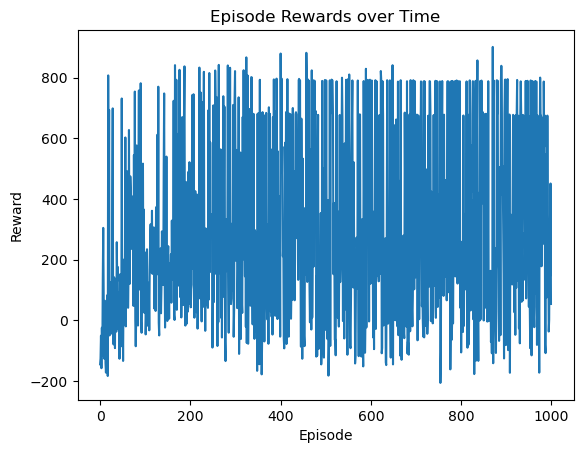

In [25]:
plot_learning_progress(LOG_DIR+'MaskablePPO_1suit/')

In [26]:
actions_limit = 1000
model12= train_maskable_ppo(n_suits=1, log_dir=LOG_DIR+'MaskablePPO_1suit/', actions_limit=actions_limit,
                        n_steps=2*actions_limit-1, batch_size=actions_limit, total_timesteps=actions_limit**2,
                        verbose=1,
                        rewards_policy={"discover_card": 4,
                                        "free pile": 16,
                                        "extend sequence": 1,
                                        "deal cards": -0.5},
                        _render_state_timeout=1_000,  _diagnostics_mode=0
                    )

Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to ../logs/training/MaskablePPO_1suit/MaskablePPO_1suits_1000_1999_1000_1
Number of complete sequences: 1
Stock cards: 0
🂠 🂩 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠
🂠 🂨 🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠
🂠   🂠 🂠 🂠 🂠 🂠 🂠 🂠 🂠
🂠   🂠 🂠 🂠 🂠 🂩 🂠 🂢 🂠
🂨   🂠 🂥 🂫 🂣   🂫 🂡 🂨
🂢   🂨 🂮 🂮 🂥   🂪   🂧
🂩   🂮 🂭 🂮 🂤   🂣   🂣
🂨   🂭   🂭 🂢   🂡   🂢
🂧   🂫   🂫 🂩   🂭   🂡
🂦   🂡   🂪     🂣   🂦
    🂮   🂤     🂩   🂥
    🂭         🂨   🂤
              🂧   🂣
              🂦   🂢
              🂥   🂡
              🂤    
terminated: True, truncated: True
---------------------------------------
| rollout/                 |          |
|    ep_len_mean           | 1e+03    |
|    ep_rew_mean           | -37      |
| spider/                  |          |
|    complete_sequences    | 1        |
|    facedown_tableu_cards | 25       |
| time/                    |          |
|    fps                   | 480      |
|    iterations            | 1        |
|    time_elapsed          | 4        |
|    total_timesteps     

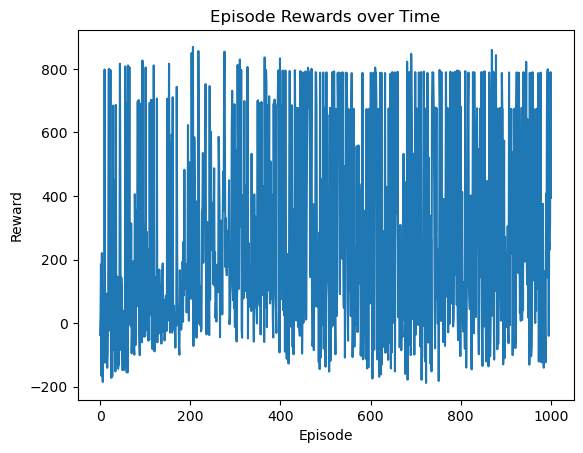

In [27]:
plot_learning_progress(LOG_DIR+'MaskablePPO_1suit/')

In [28]:
actions_limit = 1000
model12= train_maskable_ppo(n_suits=1, log_dir=LOG_DIR+'MaskablePPO_1suit/', actions_limit=actions_limit,
                        n_steps=4*actions_limit-1, batch_size=actions_limit, total_timesteps=actions_limit**2,
                        verbose=1,
                        rewards_policy={"discover_card": 4,
                                        "free pile": 16,
                                        "extend sequence": 1,
                                        "deal cards": -0.5},
                        _render_state_timeout=1_0000,  _diagnostics_mode=0
                    )

Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to ../logs/training/MaskablePPO_1suit/MaskablePPO_1suits_1000_3999_1000_1
---------------------------------------
| rollout/                 |          |
|    ep_len_mean           | 1e+03    |
|    ep_rew_mean           | -123     |
| spider/                  |          |
|    complete_sequences    | 0        |
|    facedown_tableu_cards | 40       |
| time/                    |          |
|    fps                   | 491      |
|    iterations            | 1        |
|    time_elapsed          | 8        |
|    total_timesteps       | 3999     |
---------------------------------------
------------------------------------------
| rollout/                 |             |
|    ep_len_mean           | 1e+03       |
|    ep_rew_mean           | -112        |
| spider/                  |             |
|    complete_sequences    | 1           |
|    facedown_tableu_cards | 39          |
| time/                    |             |
| 

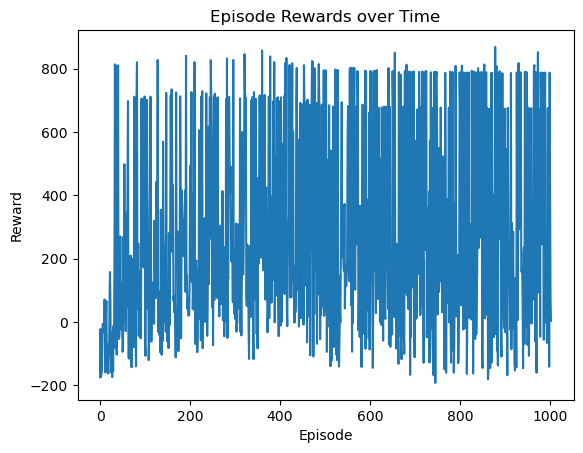

In [29]:
plot_learning_progress(LOG_DIR+'MaskablePPO_1suit/')

In [68]:
actions_limit = 1000
model12= train_maskable_ppo(n_suits=1, log_dir=LOG_DIR+'MaskablePPO_1suit/', actions_limit=actions_limit,
                        n_steps=8*actions_limit-1, batch_size=actions_limit, total_timesteps=actions_limit**2,
                        verbose=1,
                        rewards_policy={"discover_card": 4,
                                        "free pile": 16,
                                        "extend sequence": 1,
                                        "deal cards": -0.5},
                        _render_state_timeout=1_0000,  _diagnostics_mode=0
                    )

Using cpu device
Wrapping the env in a DummyVecEnv.
Logging to ../logs/training/MaskablePPO_1suit/MaskablePPO_1suits_1000_7999_1000_1
---------------------------------------
| rollout/                 |          |
|    ep_len_mean           | 1e+03    |
|    ep_rew_mean           | -40.5    |
| spider/                  |          |
|    complete_sequences    | 0        |
|    facedown_tableu_cards | 35       |
| time/                    |          |
|    fps                   | 459      |
|    iterations            | 1        |
|    time_elapsed          | 17       |
|    total_timesteps       | 7999     |
---------------------------------------
------------------------------------------
| rollout/                 |             |
|    ep_len_mean           | 1e+03       |
|    ep_rew_mean           | -19.2       |
| spider/                  |             |
|    complete_sequences    | 0           |
|    facedown_tableu_cards | 35          |
| time/                    |             |
| 

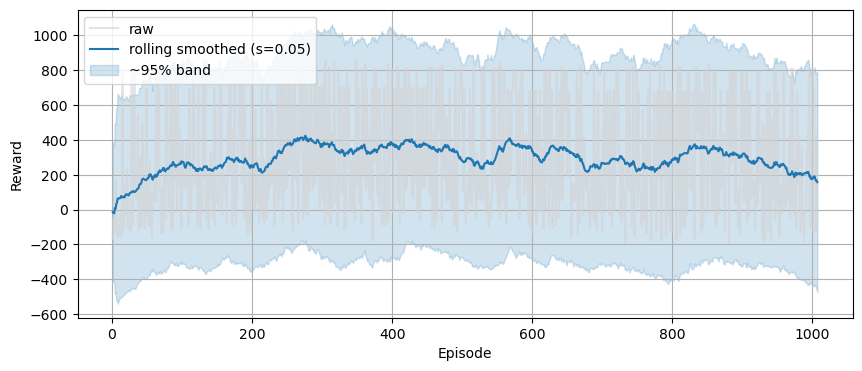

In [82]:
#plot_learning_progress(LOG_DIR+'MaskablePPO_1suit/')
plot_single_with_band(monitor_csv_path=LOG_DIR+'MaskablePPO_1suit/monitor.csv', smooth=0.05, method='rolling')

In [52]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [55]:
%reload_ext tensorboard

In [58]:
LOG_DIR+'MaskablePPO_1suit/'

'../logs/training/MaskablePPO_1suit/'

In [98]:
%tensorboard --logdir 'C:\Users\alex3\Projects\RL\SpiderSolitaire\logs\training\MaskablePPO_1suit'

Reusing TensorBoard on port 6006 (pid 3180), started 3:20:04 ago. (Use '!kill 3180' to kill it.)

#### having n_steps = 8k shows maximum effect in term of number of completed seqs and left facedown cards, n_steps =1k overfits model to earn more intermediate rewards

### 1 suit, parallel

In [90]:
log_dir = LOG_DIR+'MaskablePPO_1suit/'

import os
print(os.getcwd())

c:\Users\alex3\Projects\RL\SpiderSolitaire\notebooks


In [102]:
import subprocess
import sys
from pathlib import Path
import os

# Use the conda env python for consistent deps
conda_python = Path(r"C:\Users\alex3\.conda_envs\rl_env\python.exe")
repo_root = Path('..').resolve()  # .../Projects/RL
script_path = repo_root / 'SpiderSolitaire' / 'scripts' / 'train_maskablePPO_parallel.py'

print(f"Running: {script_path} with {conda_python}")

# Stream output live like PowerShell
proc = subprocess.Popen(
    [str(conda_python), str(script_path), '--n_envs', '28', '--total_timesteps', '1000000'],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True,
    bufsize=1
)

# Read stdout/stderr incrementally
for line in proc.stdout:
    print(line, end='')

err = proc.stderr.read()
if err:
    print("\nSTDERR:\n", err)

rc = proc.wait()
print("\nReturn code:", rc)


Running: C:\Users\alex3\Projects\RL\SpiderSolitaire\scripts\train_maskablePPO_parallel.py
Return code: 0
STDOUT:
 Using 28 environments in parallel, each with action limit 1000, total action limit per game: 1000
Using cpu device
Logging to ./SpiderSolitaire/logs/training/MaskablePPO_1suit/MaskablePPO_1suits_28_parenvs_1000_1332_1000_1
--------------------------------------------
| rollout/                      |          |
|    ep_len_mean                | 1e+03    |
|    ep_rew_mean                | -14.6    |
| spider/                       |          |
|    mean_complete_sequences    | 0.786    |
|    mean_facedown_tableu_cards | 35.7     |
|    std_complete_sequences     | 1.01     |
|    std_facedown_tableu_cards  | 6.47     |
| time/                         |          |
|    fps                        | 753      |
|    iterations                 | 1        |
|    time_elapsed               | 49       |
|    total_timesteps            | 37296    |
---------------------------------

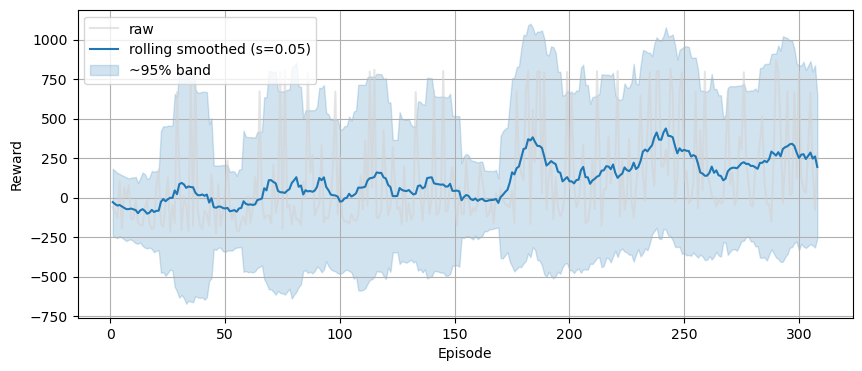

In [99]:
#plot_learning_progress(LOG_DIR+'MaskablePPO_1suit/')
plot_single_with_band(monitor_csv_path=LOG_DIR+'MaskablePPO_1suit/vecmonitor.csv', smooth=0.05, method='rolling')

In [1]:
%load_ext tensorboard

In [41]:
%tensorboard --logdir {log_dir}#"C:/Users/alex3/Projects/RL/SpiderSolitaire/logs/training/MaskablePPO_1suit" 

Reusing TensorBoard on port 6010 (pid 34168), started 1:10:23 ago. (Use '!kill 34168' to kill it.)

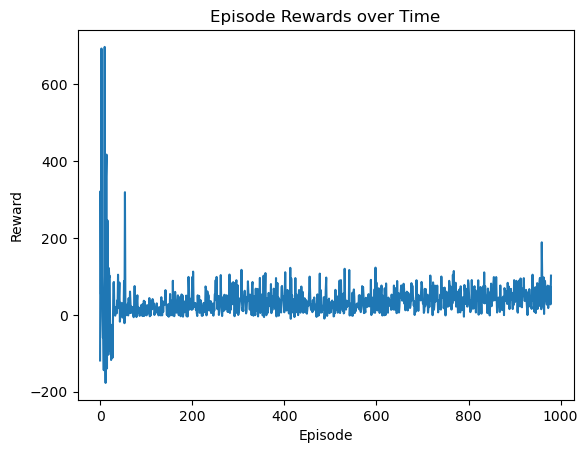

In [26]:
plot_learning_progress(log_dir+'vec')

### 4 suits

In [ ]:

log_dir = LOG_DIR+'MaskablePPO/'

# Define the masking function
def mask_fn(env):
    return env.get_action_mask()  # must return np.ndarray


env = SpiderEnv(n_actions_limit=1_000, _dtype=np.float32, _render_state_timeout=1_000, 
                    _diagnostics_mode=1, vectorize_obs=True, mask_legal_actions=True,
                #rewards_limit=True,
                rewards_policy ={"discover_card": 4,
                                 "free pile": 16,
                                 "extend sequence": 1,
                                 "deal cards": -0.5}
                   )  # must return action_mask in info
env = Monitor(env, log_dir)
env = ActionMasker(env, mask_fn)

model = MaskablePPO(
    "MlpPolicy",
    env,
    verbose=1,
    n_steps=2048,
    batch_size=256,
    learning_rate=3e-4,
    gamma=0.995,
    device="auto",
    tensorboard_log=log_dir
)


model.learn(total_timesteps=1_000_000,callback=SpiderCallback())